In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


# Data Cleaning

In [2]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [3]:
print(df.columns)
print(type(df.Salary[0]))
print(type(df['Years of Experience'][0]))

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
<class 'numpy.float64'>
<class 'numpy.float64'>


In [4]:
# Combining the education level Bachelor's degree and Bachelor's
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

Text(0, 0.5, 'Salary')

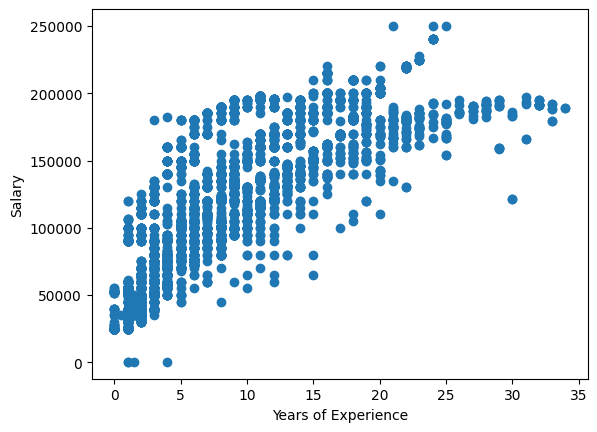

In [5]:
plt.scatter(df['Years of Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

C:\Users\carlo\AppData\Local\Temp\ipykernel_5048\2615817528.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

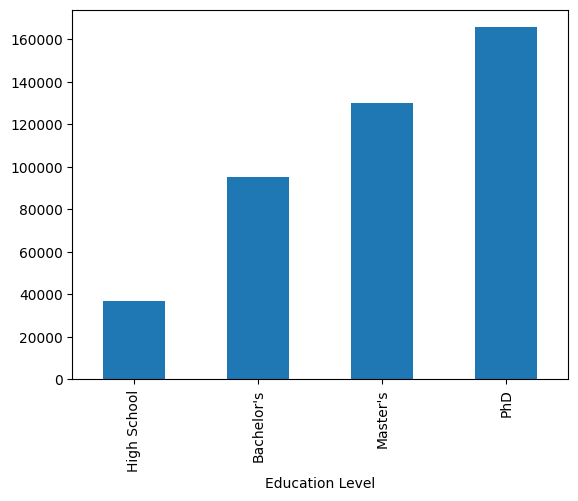

In [6]:
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [7]:
# Job Title with the most data
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Supply Chain Analyst            1
Name: count, Length: 193, dtype: int64

# Define Model

In [8]:
import torch.nn as nn
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        # self.activation2 = nn.ReLU()
        # self.layer3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        # x = self.activation2(x)
        # return self.layer3(x)
        return x

# Training

Epoch 0 - Train Loss: 0.819605827331543 | Validation Loss: 0.8516637682914734
Epoch 100 - Train Loss: 0.35573825240135193 | Validation Loss: 0.3514571487903595
Epoch 200 - Train Loss: 0.3334556818008423 | Validation Loss: 0.32003509998321533
Epoch 300 - Train Loss: 0.3240167796611786 | Validation Loss: 0.31258004903793335
Epoch 400 - Train Loss: 0.31715989112854004 | Validation Loss: 0.3100743293762207
Epoch 500 - Train Loss: 0.3118860125541687 | Validation Loss: 0.3086927831172943
Epoch 600 - Train Loss: 0.30804604291915894 | Validation Loss: 0.3079189658164978
Epoch 700 - Train Loss: 0.3053347170352936 | Validation Loss: 0.30718234181404114
Epoch 800 - Train Loss: 0.30359625816345215 | Validation Loss: 0.3057963252067566
Epoch 900 - Train Loss: 0.30249297618865967 | Validation Loss: 0.304818332195282
Epoch 1000 - Train Loss: 0.3018130362033844 | Validation Loss: 0.3046802878379822
Epoch 1100 - Train Loss: 0.3014218211174011 | Validation Loss: 0.30472078919410706
Epoch 1200 - Train Lo

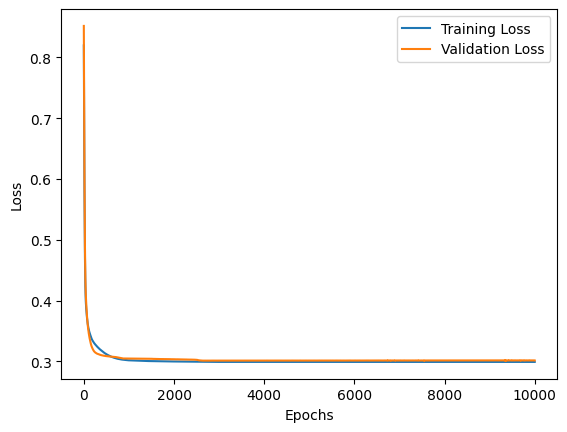

Test Loss: 0.2958254814147949


In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Filter data for a specific job title
job = 'Software Engineer'
df_job = df[df['Job Title'] == job]
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level'])

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping)

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Scale 'Years of Experience' and 'Salary' for stability
scaler = StandardScaler()
train[['Years of Experience', 'Salary']] = scaler.fit_transform(train[['Years of Experience', 'Salary']])
val[['Years of Experience', 'Salary']] = scaler.transform(val[['Years of Experience', 'Salary']])
test[['Years of Experience', 'Salary']] = scaler.transform(test[['Years of Experience', 'Salary']])

# Define the model
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        return x

# Set up model parameters
input_dim = 2  # Years of Experience, Education Level
hidden_dim = 64
output_dim = 1
model = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred), dim=1))[:, 1]

# Including Gender & Age

Epoch 0 - Train Loss: 0.9281996488571167 | Validation Loss: 1.130800485610962
Epoch 100 - Train Loss: 0.46493005752563477 | Validation Loss: 0.5243401527404785
Epoch 200 - Train Loss: 0.27475905418395996 | Validation Loss: 0.257970929145813
Epoch 300 - Train Loss: 0.1949123591184616 | Validation Loss: 0.1762438714504242
Epoch 400 - Train Loss: 0.1715070903301239 | Validation Loss: 0.15865865349769592
Epoch 500 - Train Loss: 0.1631920337677002 | Validation Loss: 0.15510842204093933
Epoch 600 - Train Loss: 0.1582254022359848 | Validation Loss: 0.15206792950630188
Epoch 700 - Train Loss: 0.1538046896457672 | Validation Loss: 0.14869262278079987
Epoch 800 - Train Loss: 0.14827421307563782 | Validation Loss: 0.14342519640922546
Epoch 900 - Train Loss: 0.1446337103843689 | Validation Loss: 0.14045672118663788
Epoch 1000 - Train Loss: 0.14124728739261627 | Validation Loss: 0.13810357451438904
Epoch 1100 - Train Loss: 0.13767416775226593 | Validation Loss: 0.1352299451828003
Epoch 1200 - Train

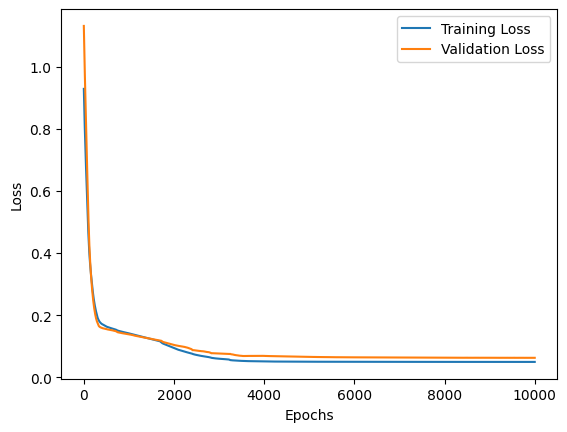

Test Loss: 0.08309537172317505


In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Filter data for a specific job title
job = 'Software Engineer'
df_job = df[df['Job Title'] == job]
df_job = df_job.dropna(subset=['Salary', 'Years of Experience', 'Education Level', 'Gender', 'Age'])

# Encode 'Education Level' for simplicity
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df_job['Education Level'] = df_job['Education Level'].map(education_mapping)

# Encode 'Gender'
gender_mapping = {'Male': 0, 'Female': 1}
df_job['Gender'] = df_job['Gender'].map(gender_mapping)

# Split the data
train, test = train_test_split(df_job, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

# Scale 'Years of Experience', 'Age', and 'Salary' for stability
scaler = StandardScaler()
train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
val[['Years of Experience', 'Salary', 'Age']] = scaler.transform(val[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

# Define the model
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        return x

# Set up model parameters
input_dim = 4  # Years of Experience, Education Level, Gender, Age
hidden_dim = 20
output_dim = 1
model = RegressionModel(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay for L2 regularization

# Prepare data for PyTorch
X_train = torch.tensor(train[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_train = torch.tensor(train['Salary'].values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(val[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_val = torch.tensor(val['Salary'].values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(test[['Years of Experience', 'Education Level', 'Gender', 'Age']].values, dtype=torch.float32)
y_test = torch.tensor(test['Salary'].values, dtype=torch.float32).view(-1, 1)

# Training loop
train_losses, val_losses = [], []
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    train_loss = criterion(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation loss
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())
        
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch} - Train Loss: {train_loss.item()} | Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item()}')

# Inverse transform predictions back to original salary scale
# We add placeholders for 'Years of Experience' and 'Age' to inverse transform correctly
y_test_pred_unscaled = scaler.inverse_transform(
    torch.cat((X_test[:, 0].unsqueeze(1), y_test_pred, X_test[:, 1:2]), dim=1))[:, 1]


# for i, pred in enumerate(y_test_pred_unscaled):
#     actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
#     print(f"Predicted Salary: {pred:.2f}, Actual Salary: {actual_salary:.2f}")

## Define Feature importance

In [11]:
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's,Marketing Manager,14.0,140000.0


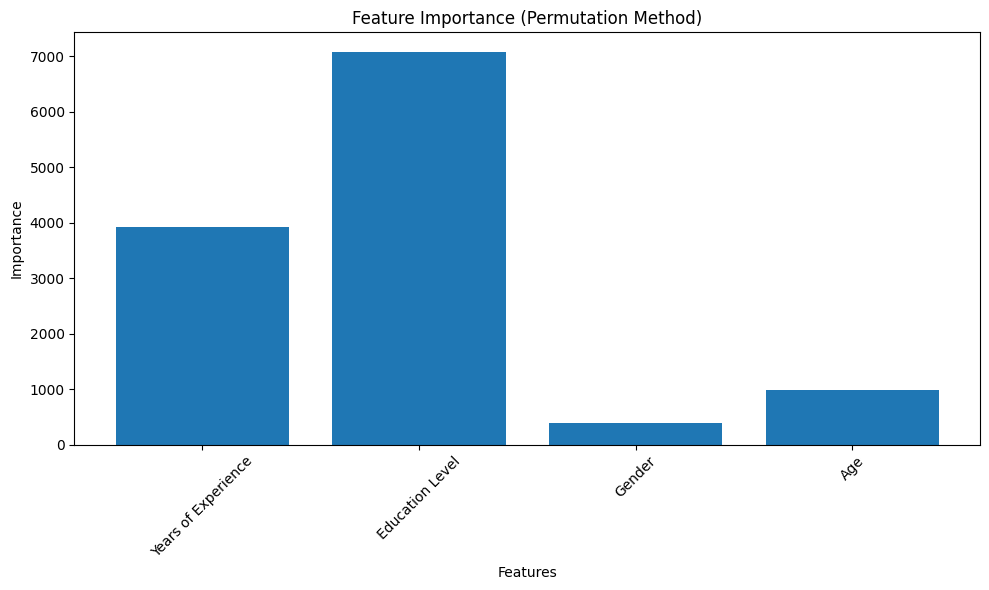

Years of Experience: 3925.3567
Education Level: 7081.0693
Gender: 380.1295
Age: 990.4357


In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, n_repeats=10):
    baseline_mse = mean_squared_error(y, model(X).detach().numpy())
    importances = []
    
    for col in range(X.shape[1]):
        feature_importances = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, col] = torch.randperm(X.shape[0])
            permuted_mse = mean_squared_error(y, model(X_permuted).detach().numpy())
            importance = permuted_mse - baseline_mse
            feature_importances.append(importance)
        importances.append(np.mean(feature_importances))
    
    return np.array(importances)

# Calculate permutation importance
feature_names = ['Years of Experience', 'Education Level', 'Gender', 'Age']
importances = permutation_importance(model, X_test, y_test)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print feature importances
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")


It's important to note that these values represent the increase in the model's error when the feature is permuted. A larger increase in error indicates that the feature is more important for the model's predictions